# 百度文库爬虫

我们在开始爬虫之前，首先要了解网页的信息和结构，然后获取请求的url和参数(payloads)来得到所要的数据并处理。接下来我们根据：
- 一.网页分析
- 二.爬虫编写
- 三.运行与结果
- 四.程序改善

## 一.网页分析

### 1.初步分析

我们首先以.txt文本文件来分析网站，从简单到复杂，从txt--->word---pdf等

我们以<<一个循环网络爬虫>>进行说明

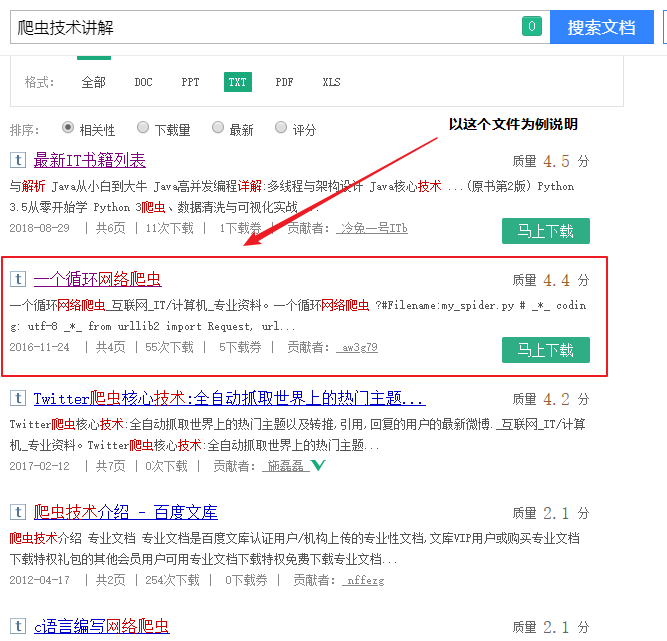

In [1]:
from IPython.display import Image
Image("./Images/1.png",width="600px",height="400px")

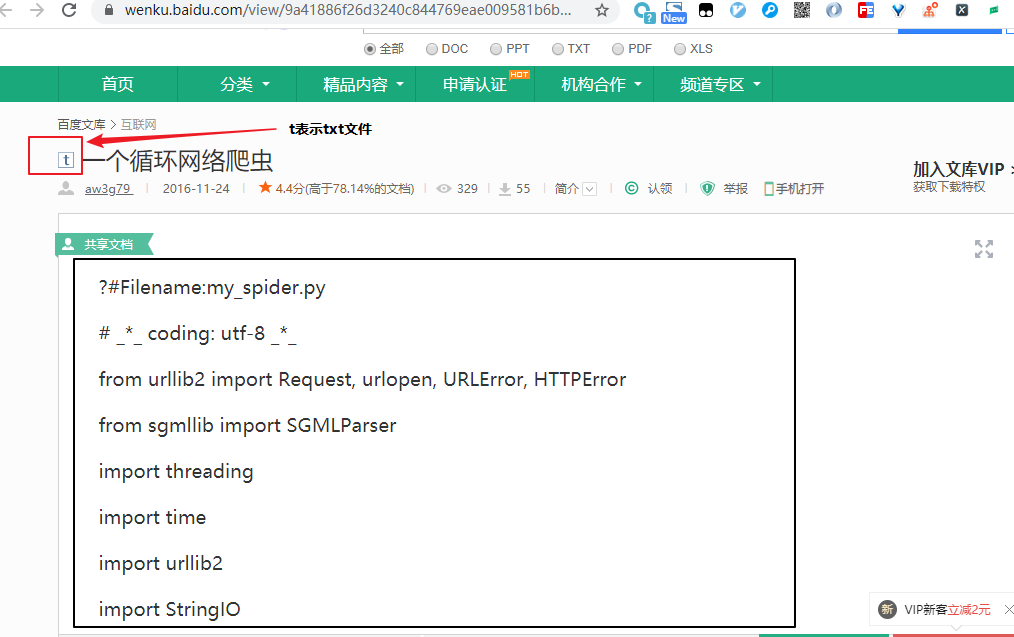

In [5]:
from IPython.display import Image
Image("./Images/0.png",width="600px",height="400px")

该百度文库的网址为：[链接](https://wenku.baidu.com/view/9a41886f26d3240c844769eae009581b6bd9bd6e.html?fr=search)

URL：https://wenku.baidu.com/view/9a41886f26d3240c844769eae009581b6bd9bd6e.html?fr=search

查看该网页的源代码，并没有我们所要的文本数据，但是有我们需要的参数如下：
- title：文件主题
- docId：文件id。这个参数很重要，我们下一步需要它跳转到其他网址
- docType：文件类型

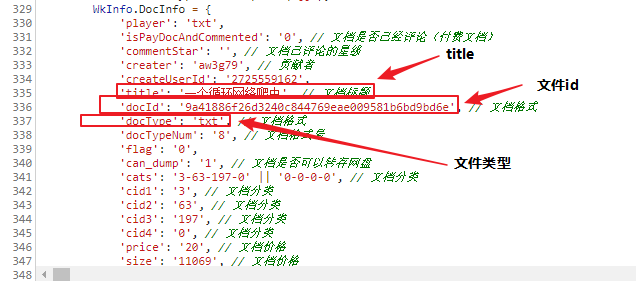

In [2]:
from IPython.display import Image
Image("./Images/2.png",width="600px",height="400px")

前提说明：对于上面数据的获取需要**re正则表达式**，对于别的网页分析器，比如lxml,bs4等不适合这样格式的数据。对于正则表达式的学习，可以参考链接：[正则表达式](https://www.yuque.com/lq6h/peo11o/re)

既然上个url中没有我们需要的数据，那么我们进行浏览器Network进行调试，寻找我们需要的数据。我们要明白一点，数据不可能无缘无故的出现在网页中，肯定存在url将数据发送过来，此数据格式大概率为**JSON**

### 2.数据发现

经过url的查找，我们终于找到我们需要的数据链接

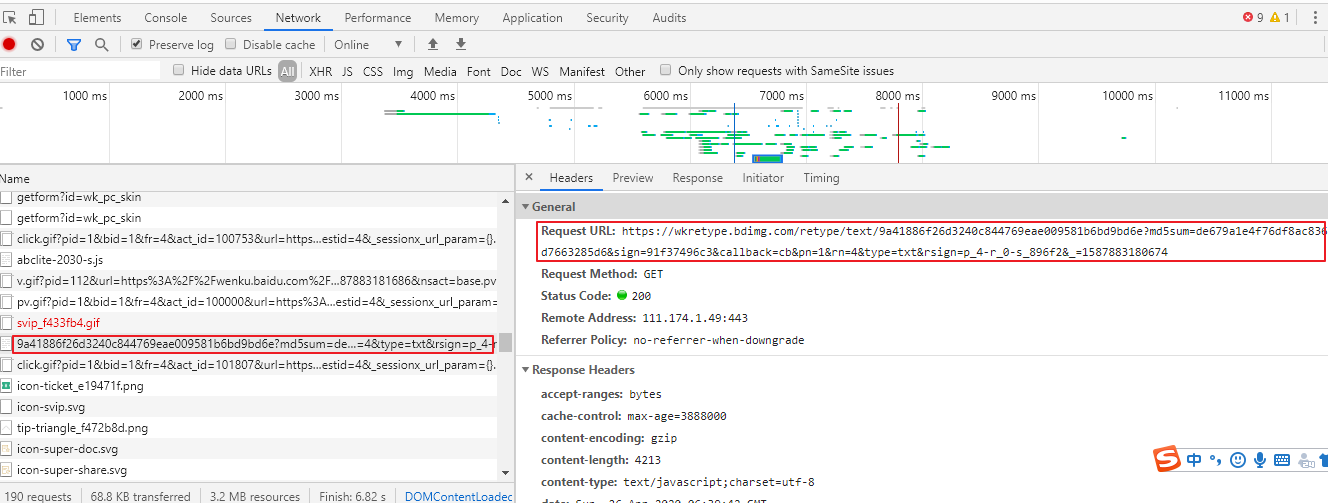

In [3]:
from IPython.display import Image
Image("./Images/3.png",width="600px",height="400px")

上面url所需的参数如下：
- md5sum: de679a1e4f76df8ac8366bd7663285d6
- sign: 91f37496c3
- callback: cb
- pn: 1
- rn: 4
- type: txt
- rsign: p_4-r_0-s_896f2
- _: 1587883180674

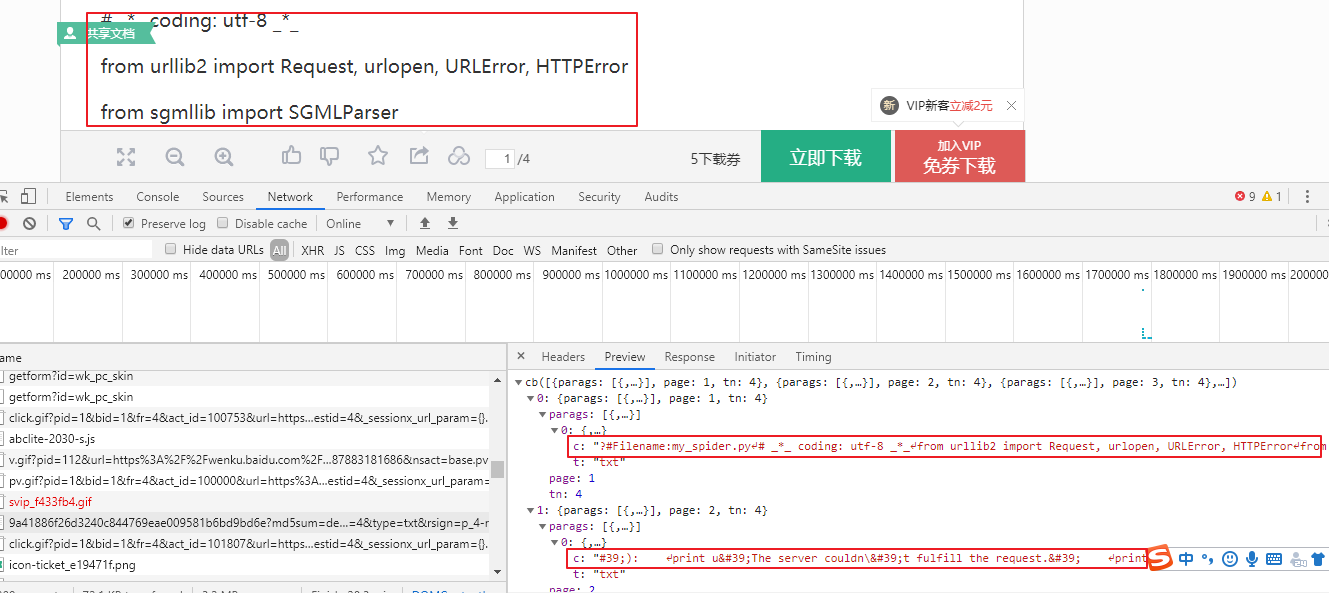

In [4]:
from IPython.display import Image
Image("./Images/4.png",width="600px",height="400px")

将以上两个重要的URL进行对比：
https://wenku.baidu.com/view/9a41886f26d3240c844769eae009581b6bd9bd6e.html?fr=search
https://wkretype.bdimg.com/retype/text/9a41886f26d3240c844769eae009581b6bd9bd6e?md5sum=de679a1e4f76df8ac8366bd7663285d6&sign=91f37496c3&callback=cb&pn=1&rn=4&type=txt&rsign=p_4-r_0-s_896f2&_=1587886244900

观察发现，其中文章的id("9a41886f26d3240c844769eae009581b6bd9bd6e")是一样的，但是文件内容还有几个参数(如md5sum,sign,rsgin,callback,pn等)

看看需获取文字详情的参数应该通过某个接口请求到的。按时间的顺序往上找，我们发现一个接口包括了需要的md5sum,sign,rsign等参数。其url为：https://wenku.baidu.com/api/doc/getdocinfo?callback=cb&doc_id=9a41886f26d3240c844769eae009581b6bd9bd6e&t=1587886245267&_=1587886244899

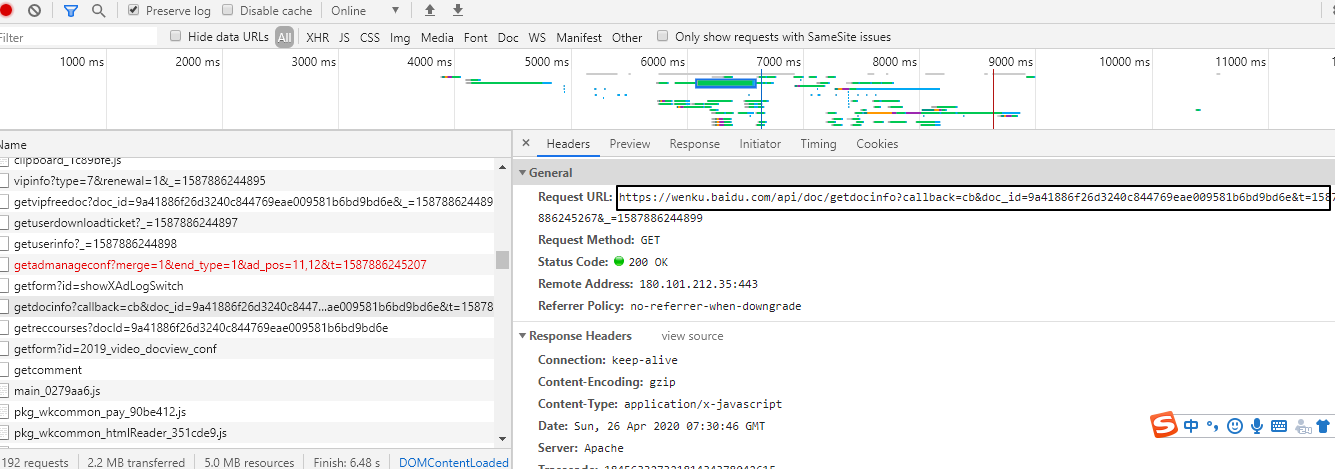

In [6]:
from IPython.display import Image
Image("./Images/5.png",width="600px",height="400px")

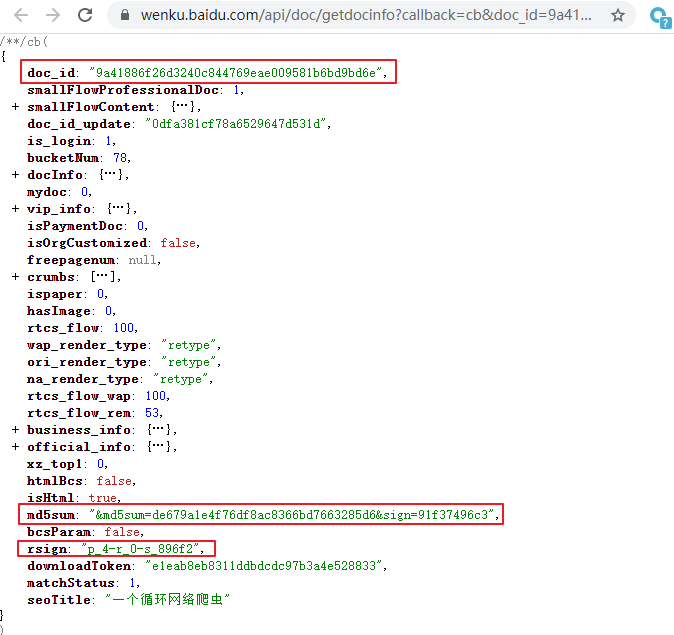

In [7]:
from IPython.display import Image
Image("./Images/6.png",width="600px",height="400px")

- md5sum: de679a1e4f76df8ac8366bd7663285d6(已获取)
- sign: 91f37496c3(已获取)
- callback: cb
- pn: 1
- rn: 4
- type: txt(已获取)
- rsign: p_4-r_0-s_896f2(已获取)
- _: 1587883180674

### 3.其他参数

通过上面的数据获取，我们还有以下参数未获取：
- callback: cb
- pn: 1
- rn: 4
- _: 1587883180674

**callback**参数是不变的为cb，**pn**为页数相关的，**_**可以猜到这个是类似时间戳的参数，对于这种前后关联的请求，处理时一般使用**Requests的Session**

In [ ]:
session=requests.session()
session.get(url).content.decode('gbk')

对此我们网页信息分析和参数获取过程已经完毕，接下来我们进行程序编程

## 二.爬虫编写

首先我们编程实现爬取过程，先进行过程调试，然后进行函数编程

通过上面的分析，整个百度文库的爬取过程可以总结为请求百度文库URL,判断文章类型,请求getcodeinfo接口相关参数,请求百度文库正文接口

### 1.请求百度文库URL

In [11]:
import requests
import re
import json
import os

session=requests.session()

In [8]:
url=input("请输入要下载的文库URL地址：")

请输入要下载的文库URL地址： https://wenku.baidu.com/view/9a41886f26d3240c844769eae009581b6bd9bd6e.html?fr=search


In [12]:
content=session.get(url).content.decode('gbk')

In [16]:
pattern=re.compile('view/(.*?).html')
res=pattern.findall(url)[0]
res

'9a41886f26d3240c844769eae009581b6bd9bd6e'

In [13]:
doc_id=re.findall('view/(.*?).html',url)[0]
doc_id

'9a41886f26d3240c844769eae009581b6bd9bd6e'

### 2.判断文章类型

In [24]:
types=re.findall(r"'docType.*?\':.*?\'(.*?)\',",content)[0]
types

'txt'

In [25]:
title=re.findall(r"'title.*?\':.*?\'(.*?)\',",content)[0]
title

'一个循环网络爬虫'

### 3.请求getcodeinfo接口相关参数

In [27]:
content_url='https://wenku.baidu.com/api/doc/getdocinfo?callback=cb&doc_id={}'.format(doc_id)
content_url

'https://wenku.baidu.com/api/doc/getdocinfo?callback=cb&doc_id=9a41886f26d3240c844769eae009581b6bd9bd6e'

In [28]:
content=session.get(content_url).content.decode('gbk')

In [29]:
md5sum=re.findall('"md5sum":"(.*?)"',content)[0]
md5sum

'&md5sum=de679a1e4f76df8ac8366bd7663285d6&sign=91f37496c3'

In [30]:
pn=re.findall('"totalPageNum":"(.*?)"',content)[0]
pn

'4'

In [31]:
rsign=re.findall('"rsign":"(.*?)"',content)[0]
rsign

'p_4-r_0-s_896f2'

### 4.请求百度文库正文接口

In [39]:
content_url='https://wkretype.bdimg.com/retype/text/'+doc_id+'?rn='+pn+'&type='+types+md5sum+'&rsign='+rsign
content=json.loads(session.get(content_url).content.decode('utf-8'))

In [34]:
result=''

for item in content:
    for i in item['parags']:
        result+=i['c'.replace('\\r','\r').replace('\\n','\n')]

In [37]:
filename=title+'.txt'

with open(filename,'w',encoding='utf-8') as f:
    f.write(result)
    
f.close()

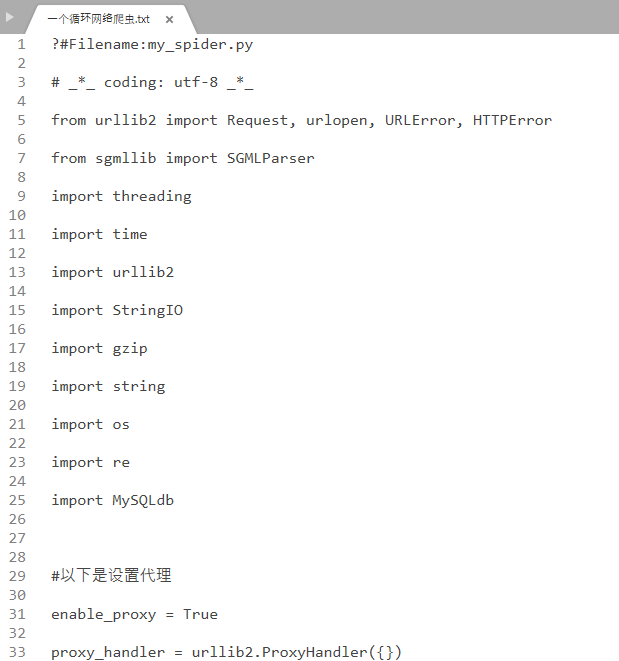

In [41]:
from IPython.display import Image
Image("./Images/7.png",width="600px",height="400px")

### 5.其他类型(doc)

对于doc文件的爬取，我们方法类型，只是提取https.*?0.json.*?)\\\\x22样式的url即对应doc每页的数据

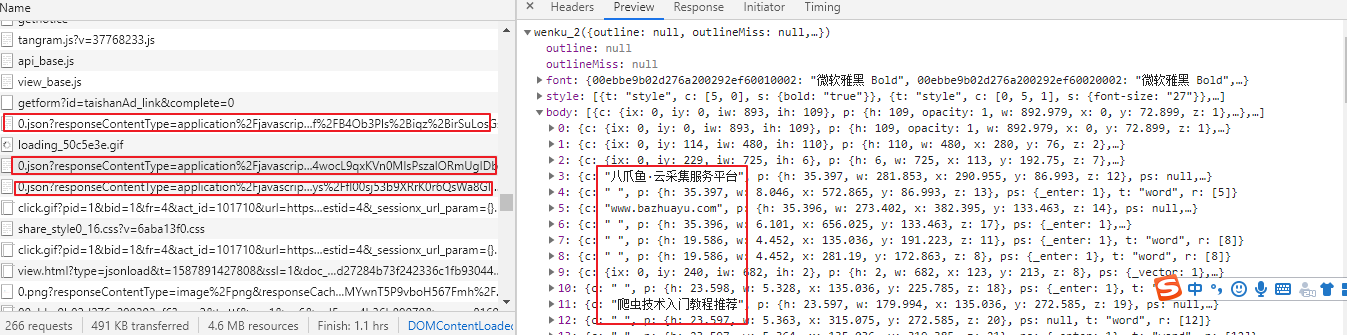

In [60]:
from IPython.display import Image
Image("./Images/8.png",width="600px",height="400px")

In [42]:
url=input("请输入要下载的文库URL地址：")

content=session.get(url).content.decode('gbk')
doc_id=re.findall('view/(.*?).html',url)[0]
types=re.findall(r"'docType.*?\':.*?\'(.*?)\',",content)[0]
title=re.findall(r"'title.*?\':.*?\'(.*?)\',",content)[0]

请输入要下载的文库URL地址： https://wenku.baidu.com/view/7cf966a96429647d27284b73f242336c1fb93044.html?fr=search


In [46]:
url_list=re.findall('(https.*?0.json.*?)\\\\x22}',content)
url_list=[addr.replace("\\\\\\/","/") for addr in url_list]

In [50]:
url_list[1]

'https://wkbjcloudbos.bdimg.com/v1/docconvert132//wk/62c22f05e9429cd4f65b8c4b36b89070/0.json?responseCacheControl=max-age%3D3888000&responseExpires=Wed%2C%2010%20Jun%202020%2017%3A17%3A46%20%2B0800&authorization=bce-auth-v1%2Ffa1126e91489401fa7cc85045ce7179e%2F2020-04-26T09%3A17%3A46Z%2F3600%2Fhost%2Fe94d9f08d4c9308a4b340a524b8c56a52e1624c8d19144de37f052db510e001c&x-bce-range=9816-20599&token=eyJ0eXAiOiJKSVQiLCJ2ZXIiOiIxLjAiLCJhbGciOiJIUzI1NiIsImV4cCI6MTU4Nzg5NjI2NiwidXJpIjp0cnVlLCJwYXJhbXMiOlsicmVzcG9uc2VDYWNoZUNvbnRyb2wiLCJyZXNwb25zZUV4cGlyZXMiLCJ4LWJjZS1yYW5nZSJdfQ%3D%3D.wX1KXsaKGWwgIukv8kOvn8PFne2TNtDkf2Zy%2FG%2BSaAI%3D.1587896266'

In [48]:
content=session.get(url_list[1]).content.decode('gbk')

In [52]:
txtlist=re.findall('"c":"(.*?)".*?"y":(.*?),',content)

In [56]:
y=0
result=''
for item in txtlist:
    if not y==item[1]:
        y=item[1]
        n='\n'
    else:
        n=''
    result+=n
    result+=item[0].encode('utf-8').decode('unicode_escape','ignore')

E:\Anaconda\envs\mypython\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: invalid escape sequence '\/'
  # Remove the CWD from sys.path while we load stuff.


In [57]:
result

'\n八爪鱼·云采集服务平台 \nwww.bazhuayu.com \n \n \n \n爬虫技术入门教程推荐 \n \n首先我们要掌握爬虫相关知识点： \n爬虫之从入门到精通（https:\\/\\/zhuanlan.zhihu.com\\/p\\/25296437） \n1、爬虫的介绍 \n2、HTTP协议的讲解 \n3、爬虫环境的搭建 \n4、爬虫之网页下载 \n5、爬虫之解析 \n6、Headers的详细讲解 \n7、爬虫之存贮 \n8、爬虫之异步加载 \n9、爬虫之多线程 \n10、scrapy的基本介绍 \n11、scrapy的正确编写方式 \n12、scrapy之下载中间件 \n13、scrapy之技巧 \n14、scrapy之分布式 \n15、爬虫总结及反爬虫技巧 '

In [58]:
result=''
for url in url_list[:-5]:
    content=session.get(url).content.decode('gbk')
    y=0
    txtlist=re.findall('"c":"(.*?)".*?"y":(.*?),',content)
    for item in txtlist:
        if not y==item[1]:
            y=item[1]
            n='\n'
        else:
            n=''
        result+=n
        result+=item[0].encode('utf-8').decode('unicode_escape','ignore')

E:\Anaconda\envs\mypython\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: invalid escape sequence '\/'
  del sys.path[0]


In [59]:
filename=title+".txt"

with open(filename,"w",encoding="utf-8") as f:
    f.write(result)
    
f.close()

### 6.其他类型(ppt)

数据说明，ppt的每页数据实质就是一张图片，我们获取每张图片就行

In [2]:
import requests
import re
import json

session=requests.session()

url=input("请输入要下载的文库URL地址：")

content=session.get(url).content.decode('gbk')
doc_id=re.findall('view/(.*?).html',url)[0]
types=re.findall(r"'docType.*?\':.*?\'(.*?)\',",content)[0]
title=re.findall(r"'title.*?\':.*?\'(.*?)\',",content)[0]

请输入要下载的文库URL地址： https://wenku.baidu.com/view/b906673ed1d233d4b14e852458fb770bf68a3b18.html?fr=search


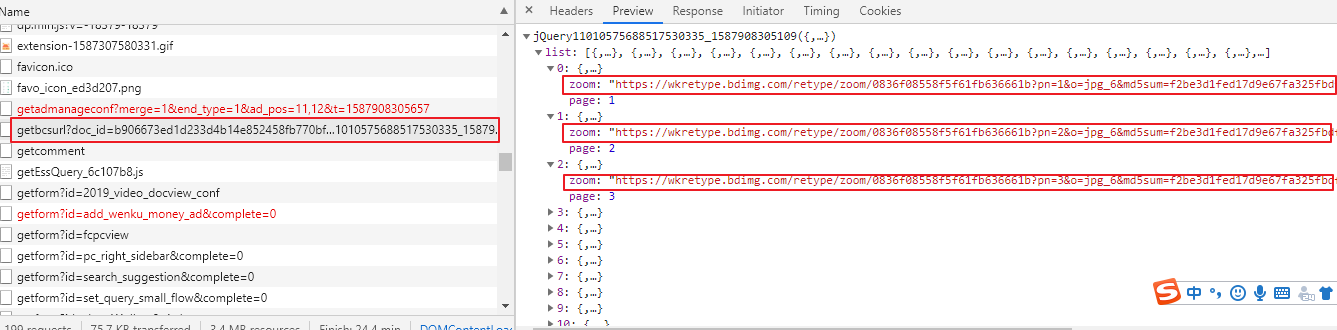

In [4]:
from IPython.display import Image
Image("./Images/9.png",width="600px",height="400px")

In [5]:
content_url='https://wenku.baidu.com/browse/getbcsurl?doc_id='+doc_id+"&pn=1&rn=99999&type=ppt"
content=session.get(content_url).content.decode('gbk')

In [7]:
url_list=re.findall('{"zoom":"(.*?)","page"',content)
url_list=[item.replace("\\",'') for item in url_list]

In [8]:
import os

if not os.path.exists(title):
    os.mkdir(title)
    
for index,url in enumerate(url_list):
    content=session.get(url).content
    path=os.path.join(title,str(index)+'.jpg')
    with open(path,'wb') as f:
        f.write(content)
        
print("图片保存在"+title+"文件夹")

图片保存在精品课件-爬虫技术文件夹


**前提说明：对于以下文件类型，我们无法保存成对应的文件类型，但可以获取其数据内容**

### 7.其他类型(pdf)

In [9]:
url=input("请输入要下载的文库URL地址：")

content=session.get(url).content.decode('gbk')
doc_id=re.findall('view/(.*?).html',url)[0]
types=re.findall(r"'docType.*?\':.*?\'(.*?)\',",content)[0]
title=re.findall(r"'title.*?\':.*?\'(.*?)\',",content)[0]

请输入要下载的文库URL地址： https://wenku.baidu.com/view/5fd3a55b3d1ec5da50e2524de518964bcf84d2b6.html?fr=search


In [12]:
url_list=re.findall('(https.*?0.json.*?)\\\\x22}',content)
url_list=[addr.replace("\\\\\\/","/") for addr in url_list]

In [37]:
result=""
for url in url_list[:-5]:
    content=session.get(url).content.decode('gbk')
    txtlists=re.findall(r'"c":"(.*?)",',content)
    
    y=0
    for item in txtlists:
        result+=item.encode('utf-8').decode('unicode_escape','ignore')
        if y%10==0:
            result+="\n"
        
            
        y+=1

E:\Anaconda\envs\mypython\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: invalid escape sequence '\/'
  


In [39]:
file_name=title+".txt"

with open(file_name,"w",encoding="utf-8") as f:
    f.write(result)
    
f.close()

### 8.其他类型(xls)

In [40]:
url=input("请输入要下载的文库URL地址：")

content=session.get(url).content.decode('gbk')
doc_id=re.findall('view/(.*?).html',url)[0]
types=re.findall(r"'docType.*?\':.*?\'(.*?)\',",content)[0]
title=re.findall(r"'title.*?\':.*?\'(.*?)\',",content)[0]

请输入要下载的文库URL地址： https://wenku.baidu.com/view/68d81664ddccda38376baffa.html?fr=search


In [41]:
url_list=re.findall('(https.*?0.json.*?)\\\\x22}',content)
url_list=[addr.replace("\\\\\\/","/") for addr in url_list]

In [45]:
set(url_list)

{'https://wkbjcloudbos.bdimg.com/v1/docconvert5099//wk/f3f81bcf705d88d1e845dc6b10429cd0/0.json?responseCacheControl=max-age%3D3888000&responseExpires=Wed%2C%2010%20Jun%202020%2023%3A15%3A31%20%2B0800&authorization=bce-auth-v1%2Ffa1126e91489401fa7cc85045ce7179e%2F2020-04-26T15%3A15%3A31Z%2F3600%2Fhost%2F51e585a7f2fc296ffaf3c75e221ed2226c5305d9827351e11869580041938259&x-bce-range=0-9453&token=eyJ0eXAiOiJKSVQiLCJ2ZXIiOiIxLjAiLCJhbGciOiJIUzI1NiIsImV4cCI6MTU4NzkxNzczMSwidXJpIjp0cnVlLCJwYXJhbXMiOlsicmVzcG9uc2VDYWNoZUNvbnRyb2wiLCJyZXNwb25zZUV4cGlyZXMiLCJ4LWJjZS1yYW5nZSJdfQ%3D%3D.E8J4bCHGAEMVRJAUwfGRrZcNrs6CJJftvA8QsrnwUhI%3D.1587917731',
 'https://wkbjcloudbos.bdimg.com/v1/docconvert5099//wk/f3f81bcf705d88d1e845dc6b10429cd0/0.json?responseCacheControl=max-age%3D3888000&responseExpires=Wed%2C%2010%20Jun%202020%2023%3A15%3A31%20%2B0800&authorization=bce-auth-v1%2Ffa1126e91489401fa7cc85045ce7179e%2F2020-04-26T15%3A15%3A31Z%2F3600%2Fhost%2F51e585a7f2fc296ffaf3c75e221ed2226c5305d9827351e1186958004

In [46]:
result=""
for url in url_list[:-2]:
    content=session.get(url).content.decode('gbk')
    txtlists=re.findall(r'"c":"(.*?)",',content)
    
    y=0
    for item in txtlists:
        result+=item.encode('utf-8').decode('unicode_escape','ignore')
        if y%10==0:
            result+="\n"
        
            
        y+=1

In [47]:
result

'接口名称\nHTTP爬虫接口接口技术描述通过WEB爬虫抓取特定URL对象，按HTML格式存储入无线城市内容库。无线城市模拟用户行为访问数据源查询页面，发出请求，得到HTML结果后，转换呈现。针对数据源能力，进行调用封装，提供HTTP请求和消息返\n回，通常是XML返回格式。同上，请求方式为WebService方式。适用采集时间适用数据量粒度非实时，小时网页形式，百、天、周、月兆以下\n即时百K以下HTTP透传接口HTTP调用接口即时百K以下WebService调用接口即时通常百K以下FTP接口\n无线城市作为FTP客户端或者服务端，取得或接受数据源的数文件形式，数非实时，小时据文件，文件格式通常为XML或据量基本无限、天、周、月CSV。可能会需要WebService调制用接口传递控制消息。\n无线城市直接连接数据源系统数据库系统取得数据。非实时，分钟SQL，数据量基、小时、天、本无限制周、月非实时，分钟文件形式，数、小时、天、\n据量基本无限周、月制DB接口本地文件接口对于传递到本地的文件，装载到无线城市系统。业务形式\n固定、半固定信息查询类应用即时查询类应用即时查询类，即时服务调用类应用。即时查询类，即时服务调用\n类应用。离线信息查询，固定、半固定信息支持。离线信息查询，固定、半固定信息支持。离线信息查\n询，固定、半固定信息支持。数据源状况要求示例不区分字段有WEB网站公开信息。无登录、验证码等。无妇婴保健需特别开发。\n有WEB网站公开查询接公积金查询口。无需特别开发。需要针对服务接口进行支付平台支付开发。接口需要针对服务接口进行目前还没有此开发。\n类接口明确交互字段需要针对服务接口进行影院信息查询开发。无需特别开发，需要公开数据库和相关文档。对数据源系统安全影响较大。此方式并不完全。从数\n据源到无线城市的数据传递可能有多种方法，如人工传递、MAIL等1.拷盘形式也是。从服务器上以文件内容FTP接口获得2.约定上传文件的格式要求\n目前还没有此类接口目前还没有此类接口数据内容够不够'

In [48]:
file_name=title+".txt"

with open(file_name,"w",encoding="utf-8") as f:
    f.write(result)
    
f.close()

## 三.运行与结果


In [149]:
import requests
import json
import re
import os
import warnings

warnings.filterwarnings('ignore')

session=requests.session()

path="F:\\桌面\\Files"

if not os.path.exists(path):
    os.mkdir(path)

def parse_txt1(code,doc_id):
    
    content_url='https://wenku.baidu.com/api/doc/getdocinfo?callback=cb&doc_id='+doc_id

    content=session.get(content_url).content.decode(code)
    md5sum=re.findall('"md5sum":"(.*?)",',content)[0]
    rsign=re.findall('"rsign":"(.*?)"',content)[0]
    pn=re.findall('"totalPageNum":"(.*?)"',content)[0]
    
    content_url='https://wkretype.bdimg.com/retype/text/'+doc_id+'?rn='+pn+'&type=txt'+md5sum+'&rsign='+rsign
    content=json.loads(session.get(content_url).content.decode('gbk'))
    
    result=''

    for item in content:
        for i in item['parags']:
            result+=i['c']
            
    return result

def parse_txt2(content,code,doc_id):
    md5sum=re.findall('"md5sum":"(.*?)",',content)[0]
    rsign=re.findall('"rsign":"(.*?)"',content)[0]
    pn=re.findall('"show_page":"(.*?)"',content)[0]
    
    content_url='https://wkretype.bdimg.com/retype/text/'+doc_id+'?rn='+pn+'&type=txt'+md5sum+'&rsign='+rsign
    content=json.loads(session.get(content_url).content.decode('utf-8'))
    
    result=''

    for item in content:
        for i in item['parags']:
            result+=i['c']
            
    return result

def parse_doc(content):
    
    url_list=re.findall(r'(https.*?0.json.*?)\\x22}',content)
    url_list=[addr.replace("\\\\\\/","/") for addr in url_list]
    
    result=""

    for url in set(url_list):
        content=session.get(url).content.decode('gbk')

        y=0
        txtlists=re.findall(r'"c":"(.*?)".*?"y":(.*?),',content)
        for item in txtlists:
            # 当item[1]的值与前面不同时，代表要换行了
            if not y==item[1]:
                y=item[1]
                n='\n'
            else:
                n=''
            result+=n
            result+=item[0].encode('utf-8').decode('unicode_escape','ignore')
    
    return result

def parse_pdf(content):
    
    url_list=re.findall(r'(https.*?0.json.*?)\\x22}',content)
    url_list=[addr.replace("\\\\\\/","/") for addr in url_list]
    
    result=""

    for url in set(url_list):
        content=session.get(url).content.decode('gbk')

        y=0
        txtlists=re.findall(r'"c":"(.*?)".*?"y":(.*?),',content)
        for item in txtlists:
            # 当item[1]的值与前面不同时，代表要换行了
            if not y==item[1]:
                y=item[1]
                n='\n'
            else:
                n=''
            result+=n
            result+=item[0].encode('utf-8').decode('unicode_escape','ignore')
    
    return result


def parse_ppt1(doc_id,title):
    
    content_url='https://wenku.baidu.com/browse/getbcsurl?doc_id='+doc_id+'&pn=1&rn=9999&type=ppt'
    content=session.get(content_url).content.decode('gbk')
    
    url_list=re.findall('{"zoom":"(.*?)","page"',content)
    url_list=[addr.replace('\\','') for addr in url_list]
    
    path="F:\\桌面\\Files"+"\\"+title

    if not os.path.exists(path):
        os.mkdir(path)
    
    for index,url in enumerate(url_list):
        content=session.get(url).content
        paths=os.path.join(path,str(index)+'.jpg')
    
        with open(paths,'wb') as f:
            f.write(content)
    print("图片保存在"+title+"文件夹")
    
def parse_ppt2(content,title):
    
    url_list=re.findall(r'(https:\\\\/\\\\/wkretype.bdimg.com.*?\d+)\\",',content)
    url_list=[addr.replace('\\\\/','/') for addr in url_list]
    
    path="F:\\桌面\\Files"+"\\"+title

    if not os.path.exists(path):
        os.mkdir(path)
    
    for index,url in enumerate(url_list3):
        content=session.get(url).content
        paths=os.path.join(path,str(index)+'.jpg')
    
    
        with open(paths,'wb') as f:
            f.write(content)
    print("图片保存在"+title+"文件夹")
    
    
def parse_xls(content):
    
    url_list=re.findall(r'(https.*?0.json.*?)\\x22}',content)
    url_list=[addr.replace("\\\\\\/","/") for addr in url_list]
    
    result=""

    for url in set(url_list):
        content=session.get(url).content.decode('gbk')

        y=0
        txtlists=re.findall(r'"c":"(.*?)".*?"y":(.*?),',content)
        for item in txtlists:
            # 当item[1]的值与前面不同时，代表要换行了
            if not y==item[1]:
                y=item[1]
                n='\n'
            else:
                n=''
            result+=n
            result+=item[0].encode('utf-8').decode('unicode_escape','ignore')
            
    result=result.replace("\udb80","").replace("\udc00","")
    
    return result
    
def save_file(title,filename,content):
    
    with open(filename,'w',encoding='utf-8') as f:
        f.write(content)
        print("文件"+title+"保存成功")
    f.close()
    

def main():
    
    print("欢迎来到百度文库文件下载：")
    print("-----------------------\r\n")
     
    
    while True:
        try:
            print("1.doc \n 2.txt \n 3.ppt \n 4.xls\n 5.ppt\n")
            types=input("请输入需要下载文件的格式(0退出)：")

            if types=="0":
                break

            if types not in ['txt','doc','pdf','ppt','xls']:
                print("抱歉文件格式错误，请重新输入!")
                continue


            url=input("请输入下载的文库URL地址：")

            # 网页内容
            response=session.get(url)

            code=re.findall('charset=(.*?)"',response.text)[0]

            if code.lower()!='utf-8':
                code='gbk'

            content=response.content.decode(code)

            # 文件id
            doc_id=re.findall('view/(.*?).html',url)[0]
            # 文件类型
            #types=re.findall(r"docType.*?:.*?'(.*?)'",content)[0]
            # 文件主题
            #title=re.findall(r"title.*?:.*?'(.*?)'",content)[0]

            if types=='txt':
                md5sum=re.findall('"md5sum":"(.*?)",',content)
                if md5sum!=[]:
                    result=parse_txt2(content,code,doc_id)
                    title=re.findall(r'<title>(.*?). ',content)[0]
                    #filename=os.getcwd()+"\\Files\\"+title+'.txt'
                    filename=path+"\\"+title+".txt"
                    save_file(title,filename,result)
                else: 
                    result=parse_txt1(code,doc_id)
                    title=re.findall(r"title.*?:.*?'(.*?)'",content)[0]
                    #filename=os.getcwd()+"\\Files\\"+title+'.txt'
                    filename=path+"\\"+title+".txt"
                    save_file(title,filename,result)
            elif types=='doc':
                title=re.findall(r"title.*?:.*?'(.*?)'",content)[0]
                result=parse_doc(content)
                filename=path+"\\"+title+".doc"
                save_file(title,filename,result)
            elif types=='pdf':
                title=re.findall(r"title.*?:.*?'(.*?)'",content)[0]
                result=parse_pdf(content)
                filename=path+"\\"+title+".txt"
                save_file(title,filename,result)
            elif types=='ppt':
                link=re.findall('wkretype',content)
                
                if link==None:
                    title=re.findall(r"title.*?:.*?'(.*?)'",content)[0]
                    parse_ppt1(doc_id,title)
                else:
                    title=title=re.findall(r'<title>(.*?)</title>',content)[0]
                    parse_ppt2(content,title)
                    
                
            elif types=='xls':
                title=re.findall(r"title.*?:.*?'(.*?)'",content)[0]
                result=parse_xls(content)
                filename=path+"\\"+title+".txt"
                save_file(title,filename,result)
                
                
        except Exception as e:
            print(e)


if __name__=='__main__':
    main()

欢迎来到百度文库文件下载：
-----------------------

1.doc 
 2.txt 
 3.ppt 
 4.xls
 5.ppt



请输入需要下载文件的格式(0退出)： ppt
请输入下载的文库URL地址： https://wenku.baidu.com/view/bafb70ab82c4bb4cf7ec4afe04a1b0717fd5b3bf.html?fr=search


图片保存在爬虫技术ppt课件 - 百度文库文件夹
1.doc 
 2.txt 
 3.ppt 
 4.xls
 5.ppt



请输入需要下载文件的格式(0退出)： doc
请输入下载的文库URL地址： https://wenku.baidu.com/view/0ee9fbc585868762caaedd3383c4bb4cf7ecb78f.html?fr=search


文件爬虫技术是什么保存成功
1.doc 
 2.txt 
 3.ppt 
 4.xls
 5.ppt



请输入需要下载文件的格式(0退出)： xls
请输入下载的文库URL地址： 0


Invalid URL '0': No schema supplied. Perhaps you meant http://0?
1.doc 
 2.txt 
 3.ppt 
 4.xls
 5.ppt



请输入需要下载文件的格式(0退出)： 0


**具体效果演示，可以看前面的几篇文章了解**

## 四.程序改善

虽然文件内容可以下载下来，但是除了txt文件和doc文件，ppt文件外，pdf文件和xls文件无法做到与原文件排版一样

## 五.程序打包

使用pyinstaller将程序打包成可执行文件(.exe)文件，**下载链接见文末**

## 六.代码链接